In [246]:
import pandas as pd
import numpy as np
import pickle

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LassoCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error,mean_absolute_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder
from sklearn.compose import ColumnTransformer

import xgboost as xgb
from xgboost import XGBClassifier

import seaborn as sns
import matplotlib.pyplot as plt

In [247]:
df = pd.read_csv('04-data/preprocessed_app_data.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22158 entries, 0 to 22157
Data columns (total 56 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   title                     22158 non-null  object 
 1   description               22158 non-null  object 
 2   summary                   22157 non-null  object 
 3   installs                  22158 non-null  object 
 4   minInstalls               22158 non-null  float64
 5   score                     22158 non-null  float64
 6   ratings                   22158 non-null  float64
 7   reviews                   22158 non-null  float64
 8   histogram                 22158 non-null  object 
 9   price                     22158 non-null  float64
 10  free                      22158 non-null  int64  
 11  currency                  22158 non-null  object 
 12  sale                      22158 non-null  bool   
 13  offersIAP                 22158 non-null  bool   
 14  inAppP

In [248]:
df_sentiment = pd.read_csv('merged_sentiment.csv')

In [249]:
df= pd.merge(
    df,
    df_sentiment,
    how="inner",
    on='title',
    left_index=False,
    right_index=False,
    sort=True,
    suffixes=("_x", "_y"),
    copy=True,
    indicator=False,
    validate=None,
)

In [250]:
X = df[['ratings','free','containsAds','genre','editorsChoice','contentRating','year','top_developer',
        'installs_day','updated_days','has_video','compound']]

y = df['score']

In [251]:
# Split to create temporary tr and test 
X_tr, X_test, y_tr, y_test = train_test_split(X, y,test_size=.20, random_state=10)

In [252]:
X_tr_cont = X_tr[['ratings','free','containsAds','editorsChoice','year','top_developer',
        'installs_day','updated_days','has_video','compound']]

In [253]:
ohe = OneHotEncoder(drop='first', sparse=False)

ohe.fit(X_tr[['genre','contentRating']])

ohe_x_tr = ohe.transform(X_tr[['genre','contentRating']])

columns = ohe.get_feature_names(['genre','contentRating'])

ohe_x_tr_df = pd.DataFrame(ohe_x_tr, columns=columns, index=X_tr.index)

In [254]:
combo_train_df = pd.concat([X_tr_cont, ohe_x_tr_df], axis=1)

In [255]:
# Further split temporary tr to create train and val
X_train, X_val, y_train, y_val = train_test_split(combo_train_df, y_tr,test_size=.20, random_state=10)

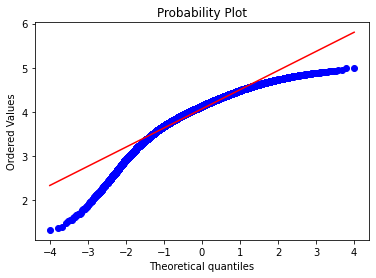

In [256]:
from scipy import stats 
fig = plt.figure() 
prob = stats.probplot(df['score'], plot=plt)

/Users/tawneykirkland/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


- Total number of ratings: 22158
- Mean of distribution of rating : 4.068657300252703
- Standard deviation: 0.449417053871379


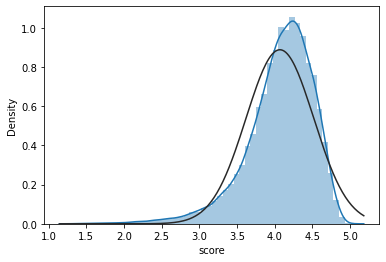

In [257]:
sns.distplot(df['score'],fit=stats.norm)
print('- Total number of ratings:', len(df['score']))
print('- Mean of distribution of rating :', np.mean(df['score']))
print('- Standard deviation:', np.std(df['score']))

## No pipeline

In [258]:
features = ['ratings', 'free', 'containsAds', 'editorsChoice', 'year',
       'top_developer', 'installs_day', 'updated_days', 'has_video',
       'compound', 'genre_Adventure', 'genre_Arcade', 'genre_Art & Design',
       'genre_Auto & Vehicles', 'genre_Beauty', 'genre_Board',
       'genre_Books & Reference', 'genre_Business', 'genre_Card',
       'genre_Casino', 'genre_Casual', 'genre_Comics', 'genre_Communication',
       'genre_Dating', 'genre_Education', 'genre_Entertainment',
       'genre_Events', 'genre_Finance', 'genre_Food & Drink',
       'genre_Health & Fitness', 'genre_House & Home',
       'genre_Libraries & Demo', 'genre_Lifestyle', 'genre_Maps & Navigation',
       'genre_Medical', 'genre_Music', 'genre_Music & Audio',
       'genre_News & Magazines', 'genre_Parenting', 'genre_Personalization',
       'genre_Photography', 'genre_Productivity', 'genre_Puzzle',
       'genre_Racing', 'genre_Role Playing', 'genre_Shopping',
       'genre_Simulation', 'genre_Social', 'genre_Sports', 'genre_Strategy',
       'genre_Tools', 'genre_Travel & Local', 'genre_Trivia',
       'genre_Video Players & Editors', 'genre_Weather', 'genre_Word',
       'contentRating_Everyone 10+', 'contentRating_Mature 17+',
       'contentRating_Teen']

In [259]:
lr = LinearRegression()

lr.fit(X_train[features], y_train)

y_pred = lr.predict(X_val[features])
print('R^2 of linear regression on val set: {:.2f}'.format(lr.score(X_val[features], y_val)))
print('MSE of linear regression on val set: {:.2f}'.format((mean_squared_error(y_val, y_pred))))
print('MAE of linear regression on val set: {:.2f}'.format((mean_absolute_error(y_val, y_pred))))

R^2 of linear regression on val set: 0.42
MSE of linear regression on val set: 0.12
MAE of linear regression on val set: 0.26


In [260]:
print('Feature coefficient results: \n')
for feature, coef in zip(X_val[features].columns, lr.coef_):
        print(feature, ':', f'{coef:.2f}')

Feature coefficient results: 

ratings : 0.00
free : 0.13
containsAds : 0.01
editorsChoice : 0.06
year : -0.01
top_developer : 0.37
installs_day : 0.00
updated_days : -0.00
has_video : 0.04
compound : 1.16
genre_Adventure : -0.12
genre_Arcade : -0.00
genre_Art & Design : -0.05
genre_Auto & Vehicles : 0.10
genre_Beauty : -0.16
genre_Board : 0.10
genre_Books & Reference : 0.10
genre_Business : 0.14
genre_Card : 0.17
genre_Casino : 0.16
genre_Casual : -0.04
genre_Comics : -0.06
genre_Communication : 0.02
genre_Dating : -0.02
genre_Education : 0.02
genre_Entertainment : -0.07
genre_Events : -0.01
genre_Finance : 0.09
genre_Food & Drink : 0.18
genre_Health & Fitness : 0.11
genre_House & Home : 0.07
genre_Libraries & Demo : -0.03
genre_Lifestyle : -0.00
genre_Maps & Navigation : 0.12
genre_Medical : -0.05
genre_Music : -0.07
genre_Music & Audio : 0.05
genre_News & Magazines : 0.01
genre_Parenting : 0.05
genre_Personalization : 0.08
genre_Photography : -0.06
genre_Productivity : 0.08
genre_Pu

In [261]:
check = X_val.copy()
check['score'] = y_val
check['pred'] = lr.predict(X_val[features])
check['resid'] = check['pred'] - check['score']

In [262]:
high_resid = check.sort_values('resid',ascending =False).head(600)

In [263]:
check.sort_values('resid',ascending =False)

,ratings,free,containsAds,editorsChoice,year,top_developer,installs_day,updated_days,has_video,compound,...,genre_Trivia,genre_Video Players & Editors,genre_Weather,genre_Word,contentRating_Everyone 10+,contentRating_Mature 17+,contentRating_Teen,score,pred,resid
10136,17466.0,1,1,0,2010,0,265.816055,362,0,0.023662,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.850772,3.786137,1.935365
1321,22315.0,1,1,0,2010,0,266.311585,75,0,0.106293,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.106250,3.911080,1.804830
19530,3864.0,1,0,0,2015,0,490.436488,30,1,0.189173,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.216495,3.893722,1.677227
13595,41818.0,1,1,0,2013,0,344.946533,7,0,0.277861,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.405864,4.056920,1.651056
10562,6694.0,1,0,0,2012,0,331.785003,507,0,0.073192,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.231689,3.835358,1.603669
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8635,3705.0,1,0,0,2015,0,480.769231,1938,0,0.126326,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.557951,3.796075,-0.761876
21361,1590.0,1,1,0,2020,0,3649.635036,138,0,0.201611,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.528302,3.761936,-0.766366
19434,41040.0,1,1,0,2017,0,755.287009,884,0,-0.032055,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.569350,3.778153,-0.791197
9226,6026.0,1,0,0,2020,0,5376.344086,33,0,-0.074129,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,4.465190,3.666289,-0.798901


In [264]:
low_resid = check[(check['resid'] >= -0.1) & (check['resid'] <= 0.1)]

In [265]:
high_resid.describe()

,ratings,free,containsAds,editorsChoice,year,top_developer,installs_day,updated_days,has_video,compound,...,genre_Trivia,genre_Video Players & Editors,genre_Weather,genre_Word,contentRating_Everyone 10+,contentRating_Mature 17+,contentRating_Teen,score,pred,resid
count,600.000000,600.0,600.000000,600.000000,600.00000,600.000000,600.000000,600.000000,600.000000,600.000000,...,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000
mean,20103.603333,1.0,0.781667,0.005000,2016.11000,0.026667,959.151252,353.898333,0.303333,0.222671,...,0.005000,0.018333,0.006667,0.006667,0.045000,0.051667,0.170000,3.430415,4.008295,0.577880
std,41390.219363,0.0,0.413460,0.070593,2.61712,0.161242,905.653304,462.267404,0.460082,0.248093,...,0.070593,0.134266,0.081445,0.081445,0.207477,0.221538,0.375946,0.482330,0.351559,0.277914
min,1083.000000,1.0,0.000000,0.000000,2010.00000,0.000000,247.892910,0.000000,0.000000,-0.296930,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.794643,3.294312,0.289598
25%,4099.750000,1.0,1.000000,0.000000,2014.00000,0.000000,424.344474,43.000000,0.000000,0.039554,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.157894,3.771689,0.365891
50%,7579.000000,1.0,1.000000,0.000000,2017.00000,0.000000,657.462196,174.500000,0.000000,0.177180,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.441121,3.950722,0.491139
75%,15502.500000,1.0,1.000000,0.000000,2018.00000,0.000000,1136.686834,497.500000,1.000000,0.378938,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.739214,4.185855,0.713671
max,362672.000000,1.0,1.000000,1.000000,2020.00000,1.000000,6993.006993,3436.000000,1.000000,0.879727,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,4.775144,5.677817,1.935365


In [266]:
low_resid.describe()

,ratings,free,containsAds,editorsChoice,year,top_developer,installs_day,updated_days,has_video,compound,...,genre_Trivia,genre_Video Players & Editors,genre_Weather,genre_Word,contentRating_Everyone 10+,contentRating_Mature 17+,contentRating_Teen,score,pred,resid
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,...,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,21938.769063,0.998911,0.848584,0.011983,2016.181917,0.081699,975.554492,353.857298,0.366013,0.290104,...,0.002179,0.016340,0.014161,0.016340,0.053377,0.037037,0.145969,4.132478,4.127075,-0.005403
std,27890.984032,0.033005,0.358649,0.108866,2.490685,0.274055,970.275167,508.276224,0.481976,0.165654,...,0.046651,0.126848,0.118220,0.126848,0.224906,0.188956,0.353268,0.289289,0.283942,0.058783
min,1155.000000,0.000000,0.000000,0.000000,2010.000000,0.000000,247.708695,0.000000,0.000000,-0.304933,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.349673,3.402923,-0.099907
25%,5628.750000,1.000000,1.000000,0.000000,2014.000000,0.000000,435.920039,38.000000,0.000000,0.179254,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.938414,3.931676,-0.057254
50%,11603.500000,1.000000,1.000000,0.000000,2017.000000,0.000000,690.608064,145.000000,0.000000,0.302065,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.112514,4.109021,-0.007214
75%,25126.250000,1.000000,1.000000,0.000000,2018.000000,0.000000,1098.599534,414.000000,1.000000,0.394318,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.311573,4.290559,0.046434
max,229914.000000,1.000000,1.000000,1.000000,2020.000000,1.000000,10000.000000,3522.000000,1.000000,0.841382,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,4.902087,4.896409,0.099771


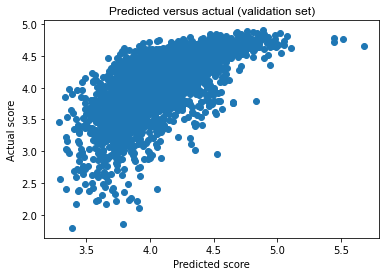

In [267]:
fig, ax = plt.subplots()
plt.scatter(y_pred,y_val)
plt.title('Predicted versus actual (validation set)',family='arial',fontsize=12)
plt.xlabel('Predicted score')
plt.ylabel('Actual score');

This model is overpredicting values

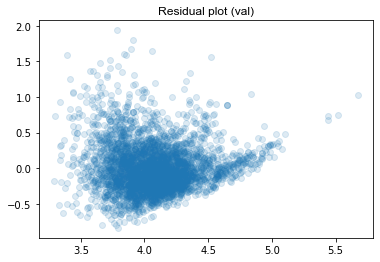

In [268]:
plt.scatter(check['pred'],check['resid'],alpha = 0.15)
plt.title('Residual plot (val)',family='arial',fontsize=12);

## Removing ratings

In [269]:
features2 = features.copy()
features2.remove('ratings')

In [270]:
lr2 = LinearRegression()

lr2.fit(X_train[features2], y_train)

y_pred2 = lr2.predict(X_val[features2])
print('R^2 of linear regression on val set: {:.2f}'.format(lr2.score(X_val[features2], y_val)))
print('MSE of linear regression on val set: {:.2f}'.format((mean_squared_error(y_val, y_pred2))))
print('MAE of linear regression on val set: {:.2f}'.format((mean_absolute_error(y_val, y_pred2))))

R^2 of linear regression on val set: 0.37
MSE of linear regression on val set: 0.12
MAE of linear regression on val set: 0.27


In [271]:
print('Feature coefficient results: \n')
for feature, coef in zip(X_val[features2].columns, lr2.coef_):
        print(feature, ':', f'{coef:.2f}')

Feature coefficient results: 

free : -0.09
containsAds : -0.01
editorsChoice : 0.14
year : -0.01
top_developer : 0.46
installs_day : 0.00
updated_days : -0.00
has_video : 0.07
compound : 1.15
genre_Adventure : -0.12
genre_Arcade : 0.01
genre_Art & Design : -0.07
genre_Auto & Vehicles : 0.08
genre_Beauty : -0.16
genre_Board : 0.10
genre_Books & Reference : 0.09
genre_Business : 0.12
genre_Card : 0.19
genre_Casino : 0.22
genre_Casual : -0.04
genre_Comics : -0.09
genre_Communication : 0.01
genre_Dating : -0.03
genre_Education : -0.01
genre_Entertainment : -0.08
genre_Events : -0.07
genre_Finance : 0.11
genre_Food & Drink : 0.17
genre_Health & Fitness : 0.10
genre_House & Home : 0.05
genre_Libraries & Demo : 0.01
genre_Lifestyle : -0.02
genre_Maps & Navigation : 0.10
genre_Medical : -0.06
genre_Music : -0.05
genre_Music & Audio : 0.03
genre_News & Magazines : 0.01
genre_Parenting : 0.03
genre_Personalization : 0.06
genre_Photography : -0.08
genre_Productivity : 0.07
genre_Puzzle : 0.12
ge

In [272]:
check2 = X_val.copy()
check2['score'] = y_val
check2['pred'] = lr2.predict(X_val[features2])
check2['resid'] = check2['pred'] - check2['score']

In [273]:
check2.sort_values('resid',ascending =False)

,ratings,free,containsAds,editorsChoice,year,top_developer,installs_day,updated_days,has_video,compound,...,genre_Trivia,genre_Video Players & Editors,genre_Weather,genre_Word,contentRating_Everyone 10+,contentRating_Mature 17+,contentRating_Teen,score,pred,resid
10136,17466.0,1,1,0,2010,0,265.816055,362,0,0.023662,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.850772,3.795361,1.944589
1321,22315.0,1,1,0,2010,0,266.311585,75,0,0.106293,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.106250,3.907250,1.801000
19530,3864.0,1,0,0,2015,0,490.436488,30,1,0.189173,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.216495,3.997850,1.781355
10562,6694.0,1,0,0,2012,0,331.785003,507,0,0.073192,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.231689,3.893729,1.662040
7644,6727.0,1,1,0,2014,0,389.559797,15,0,-0.223204,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.794643,3.417820,1.623177
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17626,35503.0,1,1,0,2014,0,439.367311,1871,1,0.305156,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.720956,3.947298,-0.773658
3008,7382.0,1,1,0,2013,0,352.360817,14,0,0.053026,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.630582,3.836995,-0.793587
19303,80941.0,1,1,0,2017,0,731.528895,426,1,0.086759,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.742094,3.945743,-0.796351
17090,36384.0,1,0,0,2018,0,1153.402537,26,1,0.032412,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.697826,3.895965,-0.801861


## Removing installs / day

In [274]:
features3 = features2.copy()
features3.remove('installs_day')

In [203]:
lr3 = LinearRegression()

lr3.fit(X_train[features3], y_train)

y_pred3 = lr3.predict(X_val[features3])
print('R^2 of linear regression on val set: {:.2f}'.format(lr3.score(X_val[features3], y_val)))
print('MSE of linear regression on val set: {:.2f}'.format((mean_squared_error(y_val, y_pred3))))
print('MAE of linear regression on val set: {:.2f}'.format((mean_absolute_error(y_val, y_pred3))))

R^2 of linear regression on val set: 0.37
MSE of linear regression on val set: 0.12
MAE of linear regression on val set: 0.27


In [137]:
print('Feature coefficient results: \n')
for feature, coef in zip(X_val[features3].columns, lr3.coef_):
        print(feature, ':', f'{coef:.2f}')

Feature coefficient results: 

free : -0.09
containsAds : -0.01
editorsChoice : 0.14
year : -0.01
top_developer : 0.46
updated_days : -0.00
has_video : 0.07
compound : 1.15
genre_Adventure : -0.12
genre_Arcade : 0.01
genre_Art & Design : -0.07
genre_Auto & Vehicles : 0.08
genre_Beauty : -0.16
genre_Board : 0.10
genre_Books & Reference : 0.09
genre_Business : 0.12
genre_Card : 0.19
genre_Casino : 0.22
genre_Casual : -0.04
genre_Comics : -0.10
genre_Communication : 0.01
genre_Dating : -0.03
genre_Education : -0.01
genre_Entertainment : -0.08
genre_Events : -0.08
genre_Finance : 0.11
genre_Food & Drink : 0.16
genre_Health & Fitness : 0.10
genre_House & Home : 0.06
genre_Libraries & Demo : 0.02
genre_Lifestyle : -0.02
genre_Maps & Navigation : 0.10
genre_Medical : -0.05
genre_Music : -0.04
genre_Music & Audio : 0.03
genre_News & Magazines : 0.01
genre_Parenting : 0.03
genre_Personalization : 0.06
genre_Photography : -0.08
genre_Productivity : 0.06
genre_Puzzle : 0.12
genre_Racing : -0.03
g

In [138]:
check3 = X_val.copy()
check3['score'] = y_val
check3['pred'] = lr3.predict(X_val[features3])
check3['resid'] = check3['pred'] - check3['score']

In [139]:
check3.sort_values('resid',ascending =False)

,ratings,free,containsAds,editorsChoice,year,top_developer,installs_day,updated_days,has_video,compound,...,genre_Trivia,genre_Video Players & Editors,genre_Weather,genre_Word,contentRating_Everyone 10+,contentRating_Mature 17+,contentRating_Teen,score,pred,resid
10136,17466.0,1,1,0,2010,0,265.816055,362,0,0.023662,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.850772,3.780270,1.929498
19530,3864.0,1,0,0,2015,0,490.436488,30,1,0.189173,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.216495,4.003933,1.787438
1321,22315.0,1,1,0,2010,0,266.311585,75,0,0.106293,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.106250,3.892356,1.786106
10562,6694.0,1,0,0,2012,0,331.785003,507,0,0.073192,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.231689,3.888171,1.656482
7644,6727.0,1,1,0,2014,0,389.559797,15,0,-0.223204,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.794643,3.419089,1.624446
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19303,80941.0,1,1,0,2017,0,731.528895,426,1,0.086759,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.742094,3.952528,-0.789566
9226,6026.0,1,0,0,2020,0,5376.344086,33,0,-0.074129,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,4.465190,3.670493,-0.794697
3008,7382.0,1,1,0,2013,0,352.360817,14,0,0.053026,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.630582,3.835578,-0.795004
17090,36384.0,1,0,0,2018,0,1153.402537,26,1,0.032412,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.697826,3.902403,-0.795423


## Removing updated days

In [275]:
features4 = features3.copy()
features4.remove('updated_days')

In [276]:
lr4 = LinearRegression()

lr4.fit(X_train[features4], y_train)

y_pred4 = lr4.predict(X_val[features4])
print('R^2 of linear regression on val set: {:.2f}'.format(lr4.score(X_val[features4], y_val)))
print('MSE of linear regression on val set: {:.2f}'.format(mean_squared_error(y_val, y_pred4)))
print('MAE of linear regression on val set: {:.2f}'.format((mean_absolute_error(y_val, y_pred4))))

R^2 of linear regression on val set: 0.37
MSE of linear regression on val set: 0.12
MAE of linear regression on val set: 0.27


In [142]:
print('Feature coefficient results: \n')
for feature, coef in zip(X_val[features4].columns, lr4.coef_):
        print(feature, ':', f'{coef:.2f}')

Feature coefficient results: 

free : -0.10
containsAds : -0.01
editorsChoice : 0.15
year : -0.00
top_developer : 0.47
has_video : 0.07
compound : 1.16
genre_Adventure : -0.11
genre_Arcade : 0.01
genre_Art & Design : -0.06
genre_Auto & Vehicles : 0.10
genre_Beauty : -0.14
genre_Board : 0.12
genre_Books & Reference : 0.11
genre_Business : 0.15
genre_Card : 0.21
genre_Casino : 0.24
genre_Casual : -0.03
genre_Comics : -0.08
genre_Communication : 0.03
genre_Dating : -0.00
genre_Education : 0.01
genre_Entertainment : -0.07
genre_Events : -0.06
genre_Finance : 0.15
genre_Food & Drink : 0.20
genre_Health & Fitness : 0.12
genre_House & Home : 0.08
genre_Libraries & Demo : 0.01
genre_Lifestyle : -0.00
genre_Maps & Navigation : 0.13
genre_Medical : -0.02
genre_Music : -0.03
genre_Music & Audio : 0.05
genre_News & Magazines : 0.05
genre_Parenting : 0.06
genre_Personalization : 0.07
genre_Photography : -0.07
genre_Productivity : 0.08
genre_Puzzle : 0.13
genre_Racing : -0.04
genre_Role Playing : -0

In [143]:
check3 = X_val.copy()
check3['score'] = y_val
check3['pred'] = lr3.predict(X_val[features3])
check3['resid'] = check3['pred'] - check3['score']

In [144]:
check3.sort_values('resid',ascending =False)

,ratings,free,containsAds,editorsChoice,year,top_developer,installs_day,updated_days,has_video,compound,...,genre_Trivia,genre_Video Players & Editors,genre_Weather,genre_Word,contentRating_Everyone 10+,contentRating_Mature 17+,contentRating_Teen,score,pred,resid
10136,17466.0,1,1,0,2010,0,265.816055,362,0,0.023662,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.850772,3.780270,1.929498
19530,3864.0,1,0,0,2015,0,490.436488,30,1,0.189173,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.216495,4.003933,1.787438
1321,22315.0,1,1,0,2010,0,266.311585,75,0,0.106293,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.106250,3.892356,1.786106
10562,6694.0,1,0,0,2012,0,331.785003,507,0,0.073192,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.231689,3.888171,1.656482
7644,6727.0,1,1,0,2014,0,389.559797,15,0,-0.223204,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.794643,3.419089,1.624446
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19303,80941.0,1,1,0,2017,0,731.528895,426,1,0.086759,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.742094,3.952528,-0.789566
9226,6026.0,1,0,0,2020,0,5376.344086,33,0,-0.074129,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,4.465190,3.670493,-0.794697
3008,7382.0,1,1,0,2013,0,352.360817,14,0,0.053026,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.630582,3.835578,-0.795004
17090,36384.0,1,0,0,2018,0,1153.402537,26,1,0.032412,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.697826,3.902403,-0.795423


## Removing year and mature

In [277]:
features5 = features4.copy()
features5.remove('year')
features5.remove('contentRating_Mature 17+')

In [278]:
lr5 = LinearRegression()

lr5.fit(X_train[features5], y_train)

y_pred5 = lr5.predict(X_val[features5])
print('R^2 of linear regression on val set: {:.2f}'.format(lr5.score(X_val[features5], y_val)))
print('MSE of linear regression on val set: {:.2f}'.format((mean_squared_error(y_val, y_pred5))))
print('MAE of linear regression on val set: {:.2f}'.format((mean_absolute_error(y_val, y_pred5))))

R^2 of linear regression on val set: 0.37
MSE of linear regression on val set: 0.12
MAE of linear regression on val set: 0.27


In [279]:
print('Feature coefficient results: \n')
for feature, coef in zip(X_val[features5].columns, lr5.coef_):
        print(feature, ':', f'{coef:.2f}')

Feature coefficient results: 

free : -0.11
containsAds : -0.02
editorsChoice : 0.15
top_developer : 0.47
has_video : 0.07
compound : 1.15
genre_Adventure : -0.12
genre_Arcade : 0.01
genre_Art & Design : -0.06
genre_Auto & Vehicles : 0.10
genre_Beauty : -0.14
genre_Board : 0.13
genre_Books & Reference : 0.12
genre_Business : 0.16
genre_Card : 0.22
genre_Casino : 0.25
genre_Casual : -0.03
genre_Comics : -0.08
genre_Communication : 0.04
genre_Dating : 0.00
genre_Education : 0.02
genre_Entertainment : -0.06
genre_Events : -0.06
genre_Finance : 0.15
genre_Food & Drink : 0.21
genre_Health & Fitness : 0.13
genre_House & Home : 0.10
genre_Libraries & Demo : 0.01
genre_Lifestyle : 0.00
genre_Maps & Navigation : 0.14
genre_Medical : -0.01
genre_Music : -0.04
genre_Music & Audio : 0.05
genre_News & Magazines : 0.06
genre_Parenting : 0.07
genre_Personalization : 0.07
genre_Photography : -0.07
genre_Productivity : 0.09
genre_Puzzle : 0.13
genre_Racing : -0.03
genre_Role Playing : -0.03
genre_Shopp

In [155]:
check5 = X_val.copy()
check5['score'] = y_val
check5['pred'] = lr5.predict(X_val[features5])
check5['resid'] = check5['pred'] - check5['score']

In [156]:
check5.sort_values('resid',ascending =False)

,ratings,free,containsAds,editorsChoice,year,top_developer,installs_day,updated_days,has_video,compound,...,genre_Trivia,genre_Video Players & Editors,genre_Weather,genre_Word,contentRating_Everyone 10+,contentRating_Mature 17+,contentRating_Teen,score,pred,resid
10136,17466.0,1,1,0,2010,0,265.816055,362,0,0.023662,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.850772,3.728918,1.878146
19530,3864.0,1,0,0,2015,0,490.436488,30,1,0.189173,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.216495,3.977091,1.760597
1321,22315.0,1,1,0,2010,0,266.311585,75,0,0.106293,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.106250,3.824135,1.717885
10562,6694.0,1,0,0,2012,0,331.785003,507,0,0.073192,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.231689,3.858938,1.627249
1394,16883.0,1,1,0,2019,0,1519.756839,23,1,0.033283,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.269458,3.866692,1.597234
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17090,36384.0,1,0,0,2018,0,1153.402537,26,1,0.032412,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.697826,3.913868,-0.783958
19303,80941.0,1,1,0,2017,0,731.528895,426,1,0.086759,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.742094,3.957232,-0.784862
21987,9436.0,1,1,0,2010,0,263.365815,13,0,0.093316,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.653040,3.857272,-0.795768
3008,7382.0,1,1,0,2013,0,352.360817,14,0,0.053026,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.630582,3.817236,-0.813346


## Removing weather and dating

In [284]:
features6 = features5.copy()
features6.remove('genre_Weather')
features6.remove('genre_Dating')

In [285]:
lr6 = LinearRegression()

lr6.fit(X_train[features6], y_train)

y_pred6 = lr6.predict(X_val[features6])
print('R^2 of linear regression on val set: {:.2f}'.format(lr6.score(X_val[features6], y_val)))
print('MSE of linear regression on val set: {:.2f}'.format((mean_squared_error(y_val, y_pred6))))
print('MAE of linear regression on val set: {:.2f}'.format((mean_absolute_error(y_val, y_pred6))))

R^2 of linear regression on val set: 0.37
MSE of linear regression on val set: 0.12
MAE of linear regression on val set: 0.27


In [286]:
print('Feature coefficient results: \n')
for feature, coef in zip(X_val[features6].columns, lr6.coef_):
        print(feature, ':', f'{coef:.2f}')

Feature coefficient results: 

free : -0.11
containsAds : -0.02
editorsChoice : 0.15
top_developer : 0.47
has_video : 0.07
compound : 1.15
genre_Adventure : -0.12
genre_Arcade : 0.01
genre_Art & Design : -0.06
genre_Auto & Vehicles : 0.09
genre_Beauty : -0.15
genre_Board : 0.12
genre_Books & Reference : 0.12
genre_Business : 0.16
genre_Card : 0.22
genre_Casino : 0.24
genre_Casual : -0.03
genre_Comics : -0.08
genre_Communication : 0.03
genre_Education : 0.02
genre_Entertainment : -0.06
genre_Events : -0.06
genre_Finance : 0.15
genre_Food & Drink : 0.20
genre_Health & Fitness : 0.13
genre_House & Home : 0.09
genre_Libraries & Demo : 0.01
genre_Lifestyle : 0.00
genre_Maps & Navigation : 0.14
genre_Medical : -0.02
genre_Music : -0.04
genre_Music & Audio : 0.05
genre_News & Magazines : 0.06
genre_Parenting : 0.07
genre_Personalization : 0.07
genre_Photography : -0.07
genre_Productivity : 0.09
genre_Puzzle : 0.13
genre_Racing : -0.04
genre_Role Playing : -0.03
genre_Shopping : 0.18
genre_Sim

In [160]:
check6 = X_val.copy()
check6['score'] = y_val
check6['pred'] = lr6.predict(X_val[features6])
check6['resid'] = check6['pred'] - check6['score']

In [161]:
check6.sort_values('resid',ascending =False)

,ratings,free,containsAds,editorsChoice,year,top_developer,installs_day,updated_days,has_video,compound,...,genre_Trivia,genre_Video Players & Editors,genre_Weather,genre_Word,contentRating_Everyone 10+,contentRating_Mature 17+,contentRating_Teen,score,pred,resid
10136,17466.0,1,1,0,2010,0,265.816055,362,0,0.023662,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.850772,3.728792,1.878020
19530,3864.0,1,0,0,2015,0,490.436488,30,1,0.189173,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.216495,3.976938,1.760443
1321,22315.0,1,1,0,2010,0,266.311585,75,0,0.106293,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.106250,3.824055,1.717805
10562,6694.0,1,0,0,2012,0,331.785003,507,0,0.073192,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.231689,3.858958,1.627269
1394,16883.0,1,1,0,2019,0,1519.756839,23,1,0.033283,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.269458,3.866456,1.596998
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17090,36384.0,1,0,0,2018,0,1153.402537,26,1,0.032412,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.697826,3.913705,-0.784121
19303,80941.0,1,1,0,2017,0,731.528895,426,1,0.086759,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.742094,3.957213,-0.784881
21987,9436.0,1,1,0,2010,0,263.365815,13,0,0.093316,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.653040,3.857211,-0.795829
3008,7382.0,1,1,0,2013,0,352.360817,14,0,0.053026,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.630582,3.817274,-0.813308


## Removing teen and lifestyle

In [287]:
features7 = features6.copy()
features7.remove('contentRating_Teen')
features7.remove('genre_Lifestyle')

In [288]:
lr7 = LinearRegression()

lr7.fit(X_train[features7], y_train)

y_pred7 = lr7.predict(X_val[features7])
print('R^2 of linear regression on val set: {:.2f}'.format(lr7.score(X_val[features7], y_val)))
print('MSE of linear regression on val set: {:.2f}'.format((mean_squared_error(y_val, y_pred7))))
print('MAE of linear regression on val set: {:.2f}'.format((mean_absolute_error(y_val, y_pred7))))

R^2 of linear regression on val set: 0.37
MSE of linear regression on val set: 0.12
MAE of linear regression on val set: 0.27


In [289]:
print('Feature coefficient results: \n')
for feature, coef in zip(X_val[features7].columns, lr7.coef_):
        print(feature, ':', f'{coef:.2f}')

Feature coefficient results: 

free : -0.11
containsAds : -0.02
editorsChoice : 0.15
top_developer : 0.47
has_video : 0.07
compound : 1.15
genre_Adventure : -0.12
genre_Arcade : 0.01
genre_Art & Design : -0.06
genre_Auto & Vehicles : 0.10
genre_Beauty : -0.14
genre_Board : 0.13
genre_Books & Reference : 0.12
genre_Business : 0.17
genre_Card : 0.21
genre_Casino : 0.23
genre_Casual : -0.03
genre_Comics : -0.08
genre_Communication : 0.04
genre_Education : 0.02
genre_Entertainment : -0.06
genre_Events : -0.06
genre_Finance : 0.16
genre_Food & Drink : 0.21
genre_Health & Fitness : 0.13
genre_House & Home : 0.10
genre_Libraries & Demo : 0.02
genre_Maps & Navigation : 0.14
genre_Medical : -0.01
genre_Music : -0.03
genre_Music & Audio : 0.05
genre_News & Magazines : 0.06
genre_Parenting : 0.07
genre_Personalization : 0.07
genre_Photography : -0.06
genre_Productivity : 0.10
genre_Puzzle : 0.14
genre_Racing : -0.03
genre_Role Playing : -0.03
genre_Shopping : 0.19
genre_Simulation : -0.10
genre_S

In [165]:
check7 = X_val.copy()
check7['score'] = y_val
check7['pred'] = lr7.predict(X_val[features7])
check7['resid'] = check7['pred'] - check7['score']

In [166]:
check7.sort_values('resid',ascending =False)

,ratings,free,containsAds,editorsChoice,year,top_developer,installs_day,updated_days,has_video,compound,...,genre_Trivia,genre_Video Players & Editors,genre_Weather,genre_Word,contentRating_Everyone 10+,contentRating_Mature 17+,contentRating_Teen,score,pred,resid
10136,17466.0,1,1,0,2010,0,265.816055,362,0,0.023662,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.850772,3.719200,1.868428
19530,3864.0,1,0,0,2015,0,490.436488,30,1,0.189173,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.216495,3.994245,1.777750
1321,22315.0,1,1,0,2010,0,266.311585,75,0,0.106293,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.106250,3.814447,1.708197
10562,6694.0,1,0,0,2012,0,331.785003,507,0,0.073192,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.231689,3.859214,1.627525
1394,16883.0,1,1,0,2019,0,1519.756839,23,1,0.033283,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.269458,3.865945,1.596487
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17090,36384.0,1,0,0,2018,0,1153.402537,26,1,0.032412,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.697826,3.913685,-0.784141
19303,80941.0,1,1,0,2017,0,731.528895,426,1,0.086759,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.742094,3.949029,-0.793065
21987,9436.0,1,1,0,2010,0,263.365815,13,0,0.093316,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.653040,3.854265,-0.798775
3008,7382.0,1,1,0,2013,0,352.360817,14,0,0.053026,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.630582,3.813592,-0.816990


## Removing sports and medical

In [291]:
features8 = features7.copy()
features8.remove('genre_Sports')
features8.remove('genre_Medical')

In [292]:
lr8 = LinearRegression()

lr8.fit(X_train[features8], y_train)

y_pred8 = lr8.predict(X_val[features8])
print('R^2 of linear regression on val set: {:.2f}'.format(lr8.score(X_val[features8], y_val)))
print('MSE of linear regression on val set: {:.2f}'.format((mean_squared_error(y_val, y_pred8))))
print('MAE of linear regression on val set: {:.2f}'.format((mean_absolute_error(y_val, y_pred8))))

R^2 of linear regression on val set: 0.37
MSE of linear regression on val set: 0.12
MAE of linear regression on val set: 0.27


In [169]:
print('Feature coefficient results: \n')
for feature, coef in zip(X_val[features8].columns, lr8.coef_):
        print(feature, ':', f'{coef:.2f}')

Feature coefficient results: 

free : -0.11
containsAds : -0.02
editorsChoice : 0.15
top_developer : 0.47
has_video : 0.07
compound : 1.15
genre_Adventure : -0.12
genre_Arcade : 0.01
genre_Art & Design : -0.06
genre_Auto & Vehicles : 0.10
genre_Beauty : -0.14
genre_Board : 0.13
genre_Books & Reference : 0.13
genre_Business : 0.17
genre_Card : 0.22
genre_Casino : 0.23
genre_Casual : -0.02
genre_Comics : -0.08
genre_Communication : 0.04
genre_Education : 0.02
genre_Entertainment : -0.06
genre_Events : -0.06
genre_Finance : 0.16
genre_Food & Drink : 0.21
genre_Health & Fitness : 0.13
genre_House & Home : 0.10
genre_Libraries & Demo : 0.02
genre_Maps & Navigation : 0.14
genre_Music : -0.03
genre_Music & Audio : 0.06
genre_News & Magazines : 0.06
genre_Parenting : 0.07
genre_Personalization : 0.07
genre_Photography : -0.06
genre_Productivity : 0.10
genre_Puzzle : 0.14
genre_Racing : -0.03
genre_Role Playing : -0.03
genre_Shopping : 0.19
genre_Simulation : -0.10
genre_Social : 0.06
genre_Str

In [170]:
check8 = X_val.copy()
check8['score'] = y_val
check8['pred'] = lr8.predict(X_val[features8])
check8['resid'] = check8['pred'] - check8['score']

In [171]:
check8.sort_values('resid',ascending =False)

,ratings,free,containsAds,editorsChoice,year,top_developer,installs_day,updated_days,has_video,compound,...,genre_Trivia,genre_Video Players & Editors,genre_Weather,genre_Word,contentRating_Everyone 10+,contentRating_Mature 17+,contentRating_Teen,score,pred,resid
10136,17466.0,1,1,0,2010,0,265.816055,362,0,0.023662,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.850772,3.718005,1.867233
19530,3864.0,1,0,0,2015,0,490.436488,30,1,0.189173,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.216495,3.997085,1.780590
1321,22315.0,1,1,0,2010,0,266.311585,75,0,0.106293,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.106250,3.813254,1.707004
10562,6694.0,1,0,0,2012,0,331.785003,507,0,0.073192,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.231689,3.859222,1.627533
1394,16883.0,1,1,0,2019,0,1519.756839,23,1,0.033283,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.269458,3.865913,1.596456
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17090,36384.0,1,0,0,2018,0,1153.402537,26,1,0.032412,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.697826,3.913662,-0.784164
19303,80941.0,1,1,0,2017,0,731.528895,426,1,0.086759,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.742094,3.948960,-0.793134
21987,9436.0,1,1,0,2010,0,263.365815,13,0,0.093316,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.653040,3.854273,-0.798767
3008,7382.0,1,1,0,2013,0,352.360817,14,0,0.053026,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.630582,3.813570,-0.817012


## Dropping casual, education, libraries

In [293]:
features9 = features8.copy()
features9.remove('genre_Casual')
features9.remove('genre_Education')
features9.remove('genre_Libraries & Demo')

In [294]:
lr9 = LinearRegression()

lr9.fit(X_train[features9], y_train)

y_pred9 = lr9.predict(X_val[features9])
print('R^2 of linear regression on val set: {:.2f}'.format(lr9.score(X_val[features9], y_val)))
print('MSE of linear regression on val set: {:.2f}'.format((mean_squared_error(y_val, y_pred9))))
print('MAE of linear regression on val set: {:.2f}'.format((mean_absolute_error(y_val, y_pred9))))

R^2 of linear regression on val set: 0.37
MSE of linear regression on val set: 0.12
MAE of linear regression on val set: 0.27


In [295]:
print('Feature coefficient results: \n')
for feature, coef in zip(X_val[features9].columns, lr9.coef_):
        print(feature, ':', f'{coef:.2f}')

Feature coefficient results: 

free : -0.10
containsAds : -0.02
editorsChoice : 0.15
top_developer : 0.47
has_video : 0.07
compound : 1.15
genre_Adventure : -0.12
genre_Arcade : 0.01
genre_Art & Design : -0.06
genre_Auto & Vehicles : 0.10
genre_Beauty : -0.14
genre_Board : 0.13
genre_Books & Reference : 0.12
genre_Business : 0.17
genre_Card : 0.22
genre_Casino : 0.23
genre_Comics : -0.08
genre_Communication : 0.04
genre_Entertainment : -0.06
genre_Events : -0.06
genre_Finance : 0.16
genre_Food & Drink : 0.21
genre_Health & Fitness : 0.13
genre_House & Home : 0.10
genre_Maps & Navigation : 0.14
genre_Music : -0.03
genre_Music & Audio : 0.06
genre_News & Magazines : 0.06
genre_Parenting : 0.07
genre_Personalization : 0.07
genre_Photography : -0.06
genre_Productivity : 0.10
genre_Puzzle : 0.14
genre_Racing : -0.03
genre_Role Playing : -0.03
genre_Shopping : 0.19
genre_Simulation : -0.10
genre_Social : 0.06
genre_Strategy : 0.09
genre_Tools : 0.07
genre_Travel & Local : 0.03
genre_Trivia :

In [176]:
check9 = X_val.copy()
check9['score'] = y_val
check9['pred'] = lr9.predict(X_val[features9])
check9['resid'] = check9['pred'] - check9['score']

In [177]:
check9.sort_values('resid',ascending =False)

,ratings,free,containsAds,editorsChoice,year,top_developer,installs_day,updated_days,has_video,compound,...,genre_Trivia,genre_Video Players & Editors,genre_Weather,genre_Word,contentRating_Everyone 10+,contentRating_Mature 17+,contentRating_Teen,score,pred,resid
10136,17466.0,1,1,0,2010,0,265.816055,362,0,0.023662,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.850772,3.717312,1.866541
19530,3864.0,1,0,0,2015,0,490.436488,30,1,0.189173,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.216495,3.998968,1.782473
1321,22315.0,1,1,0,2010,0,266.311585,75,0,0.106293,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.106250,3.812733,1.706483
10562,6694.0,1,0,0,2012,0,331.785003,507,0,0.073192,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.231689,3.860604,1.628915
1394,16883.0,1,1,0,2019,0,1519.756839,23,1,0.033283,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.269458,3.865049,1.595592
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17090,36384.0,1,0,0,2018,0,1153.402537,26,1,0.032412,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.697826,3.914475,-0.783351
19303,80941.0,1,1,0,2017,0,731.528895,426,1,0.086759,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.742094,3.948487,-0.793607
21987,9436.0,1,1,0,2010,0,263.365815,13,0,0.093316,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.653040,3.853483,-0.799557
3008,7382.0,1,1,0,2013,0,352.360817,14,0,0.053026,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.630582,3.813328,-0.817254


## Removing contains ads and arcade

In [296]:
features10 = features9.copy()
features10.remove('containsAds')
features10.remove('genre_Arcade')

In [297]:
lr10 = LinearRegression()

lr10.fit(X_train[features10], y_train)

y_pred10 = lr10.predict(X_val[features10])
print('R^2 of linear regression on val set: {:.2f}'.format(lr10.score(X_val[features10], y_val)))
print('MSE of linear regression on val set: {:.2f}'.format((mean_squared_error(y_val, y_pred10))))
print('MAE of linear regression on val set: {:.2f}'.format((mean_absolute_error(y_val, y_pred10))))

R^2 of linear regression on val set: 0.37
MSE of linear regression on val set: 0.12
MAE of linear regression on val set: 0.27


In [298]:
print('Feature coefficient results: \n')
for feature, coef in zip(X_val[features10].columns, lr10.coef_):
        print(feature, ':', f'{coef:.2f}')

Feature coefficient results: 

free : -0.12
editorsChoice : 0.15
top_developer : 0.47
has_video : 0.07
compound : 1.15
genre_Adventure : -0.12
genre_Art & Design : -0.06
genre_Auto & Vehicles : 0.10
genre_Beauty : -0.14
genre_Board : 0.12
genre_Books & Reference : 0.13
genre_Business : 0.17
genre_Card : 0.21
genre_Casino : 0.23
genre_Comics : -0.08
genre_Communication : 0.04
genre_Entertainment : -0.06
genre_Events : -0.04
genre_Finance : 0.17
genre_Food & Drink : 0.22
genre_Health & Fitness : 0.13
genre_House & Home : 0.11
genre_Maps & Navigation : 0.15
genre_Music : -0.03
genre_Music & Audio : 0.05
genre_News & Magazines : 0.06
genre_Parenting : 0.07
genre_Personalization : 0.07
genre_Photography : -0.06
genre_Productivity : 0.10
genre_Puzzle : 0.13
genre_Racing : -0.03
genre_Role Playing : -0.03
genre_Shopping : 0.20
genre_Simulation : -0.10
genre_Social : 0.06
genre_Strategy : 0.09
genre_Tools : 0.07
genre_Travel & Local : 0.03
genre_Trivia : 0.05
genre_Video Players & Editors : -0

In [186]:
check10 = X_val.copy()
check10['score'] = y_val
check10['pred'] = lr10.predict(X_val[features10])
check10['resid'] = check10['pred'] - check10['score']

In [187]:
check10.sort_values('resid',ascending =False)

,ratings,free,containsAds,editorsChoice,year,top_developer,installs_day,updated_days,has_video,compound,...,genre_Trivia,genre_Video Players & Editors,genre_Weather,genre_Word,contentRating_Everyone 10+,contentRating_Mature 17+,contentRating_Teen,score,pred,resid
10136,17466.0,1,1,0,2010,0,265.816055,362,0,0.023662,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.850772,3.723184,1.872412
19530,3864.0,1,0,0,2015,0,490.436488,30,1,0.189173,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.216495,3.984582,1.768087
1321,22315.0,1,1,0,2010,0,266.311585,75,0,0.106293,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.106250,3.817986,1.711736
10562,6694.0,1,0,0,2012,0,331.785003,507,0,0.073192,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.231689,3.845702,1.614013
1394,16883.0,1,1,0,2019,0,1519.756839,23,1,0.033283,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.269458,3.871421,1.601963
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9226,6026.0,1,0,0,2020,0,5376.344086,33,0,-0.074129,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,4.465190,3.673233,-0.791957
17090,36384.0,1,0,0,2018,0,1153.402537,26,1,0.032412,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.697826,3.904723,-0.793103
21987,9436.0,1,1,0,2010,0,263.365815,13,0,0.093316,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.653040,3.857002,-0.796038
3008,7382.0,1,1,0,2013,0,352.360817,14,0,0.053026,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.630582,3.816470,-0.814112


## Removing travel & local

In [301]:
features11 = features10.copy()
features11.remove('genre_Travel & Local')

In [302]:
lr11 = LinearRegression()

lr11.fit(X_train[features11], y_train)

y_pred11 = lr11.predict(X_val[features11])
print('R^2 of linear regression on val set: {:.2f}'.format(lr11.score(X_val[features11], y_val)))
print('MSE of linear regression on val set: {:.2f}'.format((mean_squared_error(y_val, y_pred11))))
print('MAE of linear regression on val set: {:.2f}'.format((mean_absolute_error(y_val, y_pred11))))

R^2 of linear regression on val set: 0.37
MSE of linear regression on val set: 0.12
MAE of linear regression on val set: 0.27


In [303]:
print('Feature coefficient results: \n')
for feature, coef in zip(X_val[features11].columns, lr11.coef_):
        print(feature, ':', f'{coef:.2f}')

Feature coefficient results: 

free : -0.12
editorsChoice : 0.15
top_developer : 0.47
has_video : 0.07
compound : 1.15
genre_Adventure : -0.12
genre_Art & Design : -0.06
genre_Auto & Vehicles : 0.10
genre_Beauty : -0.14
genre_Board : 0.12
genre_Books & Reference : 0.12
genre_Business : 0.17
genre_Card : 0.21
genre_Casino : 0.23
genre_Comics : -0.08
genre_Communication : 0.04
genre_Entertainment : -0.07
genre_Events : -0.04
genre_Finance : 0.17
genre_Food & Drink : 0.21
genre_Health & Fitness : 0.13
genre_House & Home : 0.10
genre_Maps & Navigation : 0.14
genre_Music : -0.04
genre_Music & Audio : 0.05
genre_News & Magazines : 0.06
genre_Parenting : 0.07
genre_Personalization : 0.07
genre_Photography : -0.07
genre_Productivity : 0.10
genre_Puzzle : 0.13
genre_Racing : -0.04
genre_Role Playing : -0.03
genre_Shopping : 0.20
genre_Simulation : -0.11
genre_Social : 0.06
genre_Strategy : 0.09
genre_Tools : 0.06
genre_Trivia : 0.05
genre_Video Players & Editors : -0.06
genre_Word : 0.21
conten

In [304]:
check11 = X_val.copy()
check11['score'] = y_val
check11['pred'] = lr11.predict(X_val[features11])
check11['resid'] = check11['pred'] - check11['score']

In [305]:
check11.sort_values('resid',ascending =False)

,ratings,free,containsAds,editorsChoice,year,top_developer,installs_day,updated_days,has_video,compound,...,genre_Trivia,genre_Video Players & Editors,genre_Weather,genre_Word,contentRating_Everyone 10+,contentRating_Mature 17+,contentRating_Teen,score,pred,resid
10136,17466.0,1,1,0,2010,0,265.816055,362,0,0.023662,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.850772,3.725967,1.875195
19530,3864.0,1,0,0,2015,0,490.436488,30,1,0.189173,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.216495,3.986748,1.770253
1321,22315.0,1,1,0,2010,0,266.311585,75,0,0.106293,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.106250,3.820718,1.714468
10562,6694.0,1,0,0,2012,0,331.785003,507,0,0.073192,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.231689,3.845867,1.614178
1394,16883.0,1,1,0,2019,0,1519.756839,23,1,0.033283,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.269458,3.871095,1.601637
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9226,6026.0,1,0,0,2020,0,5376.344086,33,0,-0.074129,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,4.465190,3.673482,-0.791708
17090,36384.0,1,0,0,2018,0,1153.402537,26,1,0.032412,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.697826,3.904401,-0.793425
21987,9436.0,1,1,0,2010,0,263.365815,13,0,0.093316,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.653040,3.857172,-0.795868
3008,7382.0,1,1,0,2013,0,352.360817,14,0,0.053026,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.630582,3.816705,-0.813877


### Test

In [319]:
X_test_cont = X_test[['free','editorsChoice','top_developer','has_video','compound']]

In [320]:
ohe = OneHotEncoder(drop='first', sparse=False)

ohe.fit(X_test[['genre','contentRating']])

ohe_x_test = ohe.transform(X_test[['genre','contentRating']])

columns = ohe.get_feature_names(['genre','contentRating'])

ohe_x_test_df = pd.DataFrame(ohe_x_test, columns=columns, index=X_test.index)

In [321]:
#Merge cont and cat DFs
combo_test_df = pd.concat([X_test_cont, ohe_x_test_df], axis=1)

In [322]:
y_pred_test = lr11.predict(combo_test_df[features11])
print('R^2 of linear regression on val set: {:.2f}'.format(lr11.score(combo_test_df[features11], y_test)))
print('MSE of linear regression on val set: {:.2f}'.format((mean_squared_error(y_test, y_pred_test))))
print('MAE of linear regression on val set: {:.2f}'.format((mean_absolute_error(y_test, y_pred_test))))

R^2 of linear regression on val set: 0.35
MSE of linear regression on val set: 0.13
MAE of linear regression on val set: 0.27
